Quick test of making classes and static hyperparameters work with JAX.

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels

In [2]:
@jax.jit
def f(x, s):
    return isokernels.CenteredSincKernel(*x).spectral_density(s)

x = rand(2)
s = rand()
jax.value_and_grad(f)(x, s)

(DeviceArray(0.64361188, dtype=float64),
 DeviceArray([0.67171805, 0.95815778], dtype=float64))

In [3]:
e = 1e-5
(f([x[0] + e, x[1]], s) - f([x[0], x[1]], s))/e

DeviceArray(0.67171805, dtype=float64)

In [4]:
e = 1e-5
(f([x[0], x[1] + e], s) - f([x[0], x[1]], s))/e

DeviceArray(0.95815778, dtype=float64)

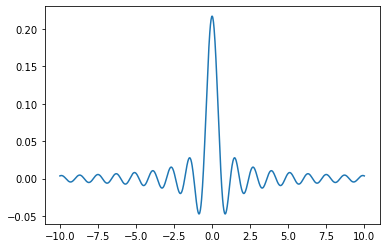

In [5]:
k = isokernels.CenteredSincKernel(*rand(2))

n = 1000
l = 10
X0 = jnp.array([[0.]])
X = linspace(-l,l,n).reshape((n,1))
plot(X, k.matrix(X0, X).T);

In [6]:
def t(k, x,y):
    X = jnp.array([[x]])
    Y = jnp.array([[y]])
    return float(k.matrix(X, Y))

x = -0.87894
y = -0.4567
v = 12.34865
l = 2.687874
k = isokernels.CenteredSincKernel

t(k(sqrt(v), l), x, y)

3.3731458197014668

In [7]:
hash(isokernels.CenteredSincKernel), hash(isokernels.SqExponentialKernel)

(4898450, 4898332)

In [8]:
import flax

theta = {
    'variance': 1.5,
    'lengthscale': jnp.pi
}

# alpha = intermediate

hyper = flax.core.frozen_dict.freeze({
    'kernel': isokernels.Matern32Kernel,
    'hilbert_order': 128,
    'time': t
})

s = 1.896465

@partial(jit, static_argnames="hyper")
def f(theta, s, hyper):
    variance = jnp.sqrt(theta['variance'])
    lengthscale = theta['lengthscale']
    kernel = hyper['kernel']
    return kernel(variance, lengthscale).spectral_density(s)

jax.value_and_grad(f)(theta, s, hyper)

ModuleNotFoundError: No module named 'flax'

In [9]:
class HilbertKernel:
    def __init__(self, theta, hyper):
        self.kernel = hyper["kernel"]
        self.var = theta["var"]
        self.scale = theta["scale"]
        self.M = hyper["M"]
        self.L = theta["L"]
    
    def kernelmatrix_root(self, t): # (len(t), M)
        return core.kernelmatrix_root_hilbert(
            self.kernel,
            self.var,
            self.scale,
            t,
            self.M,
            self.L
        )
        
    def kernelmatrix(self, x, y):
        Rx = self.kernelmatrix_root(x)
        Ry = self.kernelmatrix_root(y)
        return Rx @ Ry.T # (len(x), len(y))

theta = {
    'var': 1.5,
    'scale': jnp.pi,
    'L': 7.
}

hyper = frozen_dict.freeze({
    'kernel': isokernels.Matern32Kernel,
    'M': 128,
    't': np.linspace(-1., 10., 300)
})

k = HilbertKernel(theta, hyper)
R = k.kernelmatrix_root(hyper['t'])
plot(hyper['t'], R[:,:3]);

NameError: name 'frozen_dict' is not defined

In [10]:
#@partial(jit, static_argnames="hyper")
def testf(theta, hyper):
    k = HilbertKernel(theta, hyper)
    R = k.kernelmatrix_root(hyper['t'])
    return jnp.sum(R.T @ R)

value_and_grad(testf)(theta, hyper)

NameError: name 'value_and_grad' is not defined